Pre-requisite is the earnings from alpha vantage, clean and combined stock data from kaggle and ticker data also from kaggle. These are processed and extracted from previous analysis

In [ ]:
import pandas as pd
import numpy as np

def build_event_and_strategy_df(stock_df, earnings_df, ticker_df, window=5):
    # Step 1: Clean & Convert Dates
    stock_df["Date"] = pd.to_datetime(stock_df["Date"])
    earnings_df["reported_date_clean"] = pd.to_datetime(earnings_df["reported_date_clean"])

    # Step 2: Sort for merge
    stock_df = stock_df.sort_values(["Ticker", "Date"])

    # Step 3: Build event windows
    event_rows = []
    for (ticker, reported_date) in earnings_df[["symbol", "reported_date_clean"]].dropna().values:
        price_df = stock_df[stock_df["Ticker"] == ticker]
        idx = price_df[price_df["Date"] == reported_date].index
        if len(idx) == 0:
            continue
        loc = price_df.index.get_loc(idx[0])
        start = max(0, loc - window)
        end = min(len(price_df), loc + window + 1)
        window_df = price_df.iloc[start:end].copy()
        window_df["Days_From_Earnings"] = np.arange(start - loc, end - loc)
        window_df["Earnings_Date"] = reported_date
        window_df["symbol"] = ticker
        # Merge EPS info
        for col in ['actual_eps', 'estimated_eps', 'surprise', 'surprise_pct']:
            window_df[col] = earnings_df[(earnings_df["symbol"] == ticker) &
                                         (earnings_df["reported_date_clean"] == reported_date)][col].values[0]
        event_rows.append(window_df)

    event_df = pd.concat(event_rows).reset_index(drop=True)

    # Step 4: Add Next Day Open
    event_df["Next_Day_Open"] = event_df.groupby("Ticker")["Open"].shift(-1)

    # Step 5: Add Return Metrics
    event_df["Regular_Change%"] = 100 * (event_df["Close"] - event_df["Open"]) / event_df["Open"]
    event_df["After_Hours_Change%"] = 100 * (event_df["Next_Day_Open"] - event_df["Close"]) / event_df["Close"]

    # Step 6: Merge Ticker Metadata
    enriched_df = pd.merge(event_df, ticker_df, how="left", left_on="Ticker", right_on="Ticker")

    # Rename EPS fields
    enriched_df = enriched_df.rename(columns={
        "surprise": "EPS_Surprise",
        "surprise_pct": "EPS_Surprise_%",
        "actual_eps": "EPS_Actual",
        "estimated_eps": "EPS_Estimate"
    })

    # Reorder for modeling
    strategy_cols = [
        'Ticker', 'Earnings_Date', 'Date', 'Days_From_Earnings',
        'Open', 'Close', 'Next_Day_Open',
        'Regular_Change%', 'After_Hours_Change%', 'EPS_Actual', 'EPS_Estimate',
        'EPS_Surprise', 'EPS_Surprise_%',
        'Sector', 'Industry', 'Profitable', 'Founder_is_CEO',
        'FemaleCEO', 'Growth_in_Jobs'
    ]
    strategy_df = enriched_df[strategy_cols].dropna()

    return strategy_df


strategy_df_5 = build_event_and_strategy_df(cleaned_stock_data, combined_alpha_earnings_data, ticker_df, window=5)
strategy_df_5.to_csv("/content/strategy_df_window5.csv", index=False)
strategy_df_5.head()


Need strategy_df

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Load required datasets (replace with your own if needed)
alpha_df = combined_alpha_earnings_data.copy()

# 2. Merge alpha_df to strategy_df to ensure consistency in available tickers
available_tickers = set(strategy_df["Ticker"].unique())
relevant_tickers = ticker_df[ticker_df["Ticker"].isin(available_tickers)]

# 3. Sort by MarketCap or Revenue
top_tickers_df = relevant_tickers.sort_values(by="MarketCap_March28_M", ascending=False).head(10)
top_tickers = top_tickers_df["Ticker"].tolist()

print(f"🎯 Analyzing top tickers: {top_tickers}")

# 4. Function to train and evaluate model
def evaluate_ticker_model(ticker, df):
    df_ticker = df[df["Ticker"] == ticker].copy()
    df_ticker = df_ticker.dropna(subset=["After_Hours_Change%"])

    if len(df_ticker) < 50:
        return {"Ticker": ticker, "RMSE": None, "R2": None, "Samples": len(df_ticker)}

    y = df_ticker["After_Hours_Change%"]
    X = df_ticker.drop(columns=["Ticker", "Date", "Earnings_Date", "Company", "After_Hours_Change%", "Regular_Change%"])
    cols_to_drop = ["Ticker", "Date", "Earnings_Date", "Company", "After_Hours_Change%", "Regular_Change%"]
    existing_cols = [col for col in cols_to_drop if col in df_ticker.columns]
    X = df_ticker.drop(columns=existing_cols)


    # Handle NaNs
    X = X.replace([np.inf, -np.inf], np.nan)
    for col in X.columns:
        if X[col].dtype in ["float64", "int64"]:
            X[col] = X[col].fillna(0)
        else:
            X[col] = X[col].fillna("missing")

    # Column types
    num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    return {"Ticker": ticker, "RMSE": round(rmse, 4), "R2": round(r2, 4), "Samples": len(df_ticker)}

# 5. Run for each ticker
results = [evaluate_ticker_model(t, strategy_df) for t in top_tickers]
results_df = pd.DataFrame(results)

# 6. Save and display
results_df.to_csv("ticker_model_performance.csv", index=False)
print("✅ Saved to ticker_model_performance.csv")
results_df
rfr_results_df = results_df.copy()



In [18]:
import google.colab
import os
from google.colab import files
uploaded = files.upload()

Saving strategy_df_window9.csv to strategy_df_window9.csv


In [ ]:
import pandas as pd
combined_model_performance = pd.read_csv("combined_model_performance.csv")
combined_model_performance

,Ticker,RMSE,R2,Samples,Model
0,AAPL,NaN,NaN,34,Random Forest
1,AAPL,NaN,NaN,34,XGBoost
2,AMZN,9.4722,0.1523,713,Random Forest
3,AMZN,8.1423,0.3736,713,XGBoost
4,JPM,5.2232,0.5304,741,Random Forest
5,JPM,4.4169,0.6642,741,XGBoost
6,MSFT,3.7681,0.4777,741,Random Forest
7,MSFT,2.9839,0.6724,741,XGBoost
8,NVDA,20.6502,0.1229,643,Random Forest
9,NVDA,18.6401,0.2853,643,XGBoost


In [6]:
import pandas as pd
strategy_df_3 = pd.read_csv("strategy_df (2).csv")
strategy_df_3.head()

,Ticker,Earnings_Date,Date,Days_From_Earnings,Open,Close,Next_Day_Open,Regular_Change%,After_Hours_Change%,EPS_Actual,EPS_Estimate,EPS_Surprise,EPS_Surprise_%,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs
0,AAPL,2018-11-01,2018-10-12,-3,41.250000,42.400002,41.250000,2.787882,-2.712268,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
1,AAPL,2018-11-01,2018-10-12,-2,41.250000,42.400002,41.250000,2.787882,-2.712268,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
2,AAPL,2018-11-01,2018-10-12,-1,41.250000,42.400002,43.647499,2.787882,2.942211,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
3,AAPL,2018-11-01,2018-11-01,0,43.647499,43.820000,43.647499,0.395213,-0.393657,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
4,AAPL,2018-11-01,2018-11-01,1,43.647499,43.820000,43.647499,0.395213,-0.393657,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no


In [8]:
import pandas as pd
strategy_df_5 = pd.read_csv("strategy_df_window5.csv")
strategy_df_5.head()

,Ticker,Earnings_Date,Date,Days_From_Earnings,Open,Close,Next_Day_Open,Regular_Change%,After_Hours_Change%,EPS_Actual,EPS_Estimate,EPS_Surprise,EPS_Surprise_%,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs
0,AAPL,2022-10-27,2022-11-01,5,172.320007,175.080002,172.320007,1.601668,-1.576419,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
1,AAPL,2022-10-27,2022-11-01,5,172.320007,175.080002,172.320007,1.601668,-1.576419,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
2,AAPL,2022-07-28,2022-08-02,5,171.729996,174.830002,171.729996,1.805163,-1.773155,1.20,1.16,0.04,3.4483,Technology,"Computers, Office Equipment",yes,no,no,no
3,AAPL,2022-07-28,2022-08-02,5,171.729996,174.830002,171.729996,1.805163,-1.773155,1.20,1.16,0.04,3.4483,Technology,"Computers, Office Equipment",yes,no,no,no
4,AAPL,2022-04-28,2022-05-01,3,179.610001,174.919998,179.610001,-2.611215,2.681227,1.52,1.43,0.09,6.2937,Technology,"Computers, Office Equipment",yes,no,no,no


In [2]:
import pandas as pd
strategy_df_7 = pd.read_csv("strategy_df_window7.csv")
strategy_df_7.head()

,Ticker,Earnings_Date,Date,Days_From_Earnings,Open,Close,Next_Day_Open,Regular_Change%,After_Hours_Change%,EPS_Actual,EPS_Estimate,EPS_Surprise,EPS_Surprise_%,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs
0,AAPL,2022-10-27,2022-11-01,5,172.320007,175.080002,172.320007,1.601668,-1.576419,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
1,AAPL,2022-10-27,2022-11-01,5,172.320007,175.080002,172.320007,1.601668,-1.576419,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
2,AAPL,2022-10-27,2022-11-01,5,172.320007,175.080002,172.330002,1.601668,-1.570711,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
3,AAPL,2022-10-27,2022-11-02,6,172.330002,168.639999,172.330002,-2.141242,2.188094,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
4,AAPL,2022-10-27,2022-11-02,6,172.330002,168.639999,172.330002,-2.141242,2.188094,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no


In [15]:
import pandas as pd
strategy_df_1 = pd.read_csv("strategy_df_window1.csv")
strategy_df_1.head()

,Ticker,Earnings_Date,Date,Days_From_Earnings,Open,Close,Next_Day_Open,Regular_Change%,After_Hours_Change%,EPS_Actual,EPS_Estimate,EPS_Surprise,EPS_Surprise_%,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs
0,AAPL,2018-11-01,2018-11-01,0,43.647499,43.820000,43.647499,0.395213,-0.393657,0.7300,0.7000,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
1,AAPL,2018-11-01,2018-11-01,0,43.647499,43.820000,43.647499,0.395213,-0.393657,0.7300,0.7000,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
2,AAPL,2018-07-31,2018-08-01,1,43.587502,43.587502,43.587502,0.000000,0.000000,0.5850,0.5450,0.04,7.3394,Technology,"Computers, Office Equipment",yes,no,no,no
3,AAPL,2018-07-31,2018-08-01,1,43.587502,43.587502,43.587502,0.000000,0.000000,0.5850,0.5450,0.04,7.3394,Technology,"Computers, Office Equipment",yes,no,no,no
4,AAPL,2018-05-01,2018-05-01,0,43.360001,43.750000,43.360001,0.899445,-0.891427,0.6825,0.6725,0.01,1.4870,Technology,"Computers, Office Equipment",yes,no,no,no


In [19]:
import pandas as pd
strategy_df_9 = pd.read_csv("strategy_df_window9.csv")
strategy_df_9.head()

,Ticker,Earnings_Date,Date,Days_From_Earnings,Open,Close,Next_Day_Open,Regular_Change%,After_Hours_Change%,EPS_Actual,EPS_Estimate,EPS_Surprise,EPS_Surprise_%,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs
0,AAPL,2022-10-27,2022-11-01,5,172.320007,175.080002,172.320007,1.601668,-1.576419,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
1,AAPL,2022-10-27,2022-11-01,5,172.320007,175.080002,172.320007,1.601668,-1.576419,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
2,AAPL,2022-10-27,2022-11-01,5,172.320007,175.080002,172.330002,1.601668,-1.570711,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
3,AAPL,2022-10-27,2022-11-02,6,172.330002,168.639999,172.330002,-2.141242,2.188094,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
4,AAPL,2022-10-27,2022-11-02,6,172.330002,168.639999,172.330002,-2.141242,2.188094,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no


<ipython-input-3-904936ae88ba>:16: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-904936ae88ba>:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("rmse_comparison.png")  # Save for dashboard
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


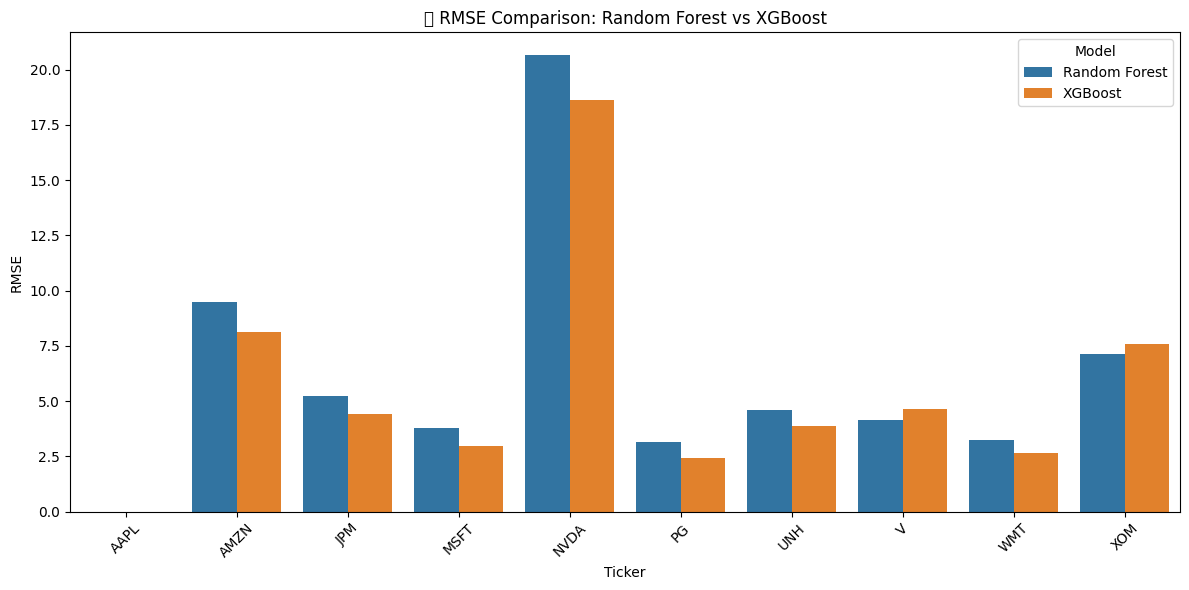

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the combined dataframe
df = pd.read_csv("combined_model_performance.csv")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Ticker", y="RMSE", hue="Model")

plt.title("📉 RMSE Comparison: Random Forest vs XGBoost")
plt.ylabel("RMSE")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("rmse_comparison.png")  # Save for dashboard
plt.show()


<ipython-input-4-fde196820e4c>:8: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-fde196820e4c>:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("r2_comparison.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


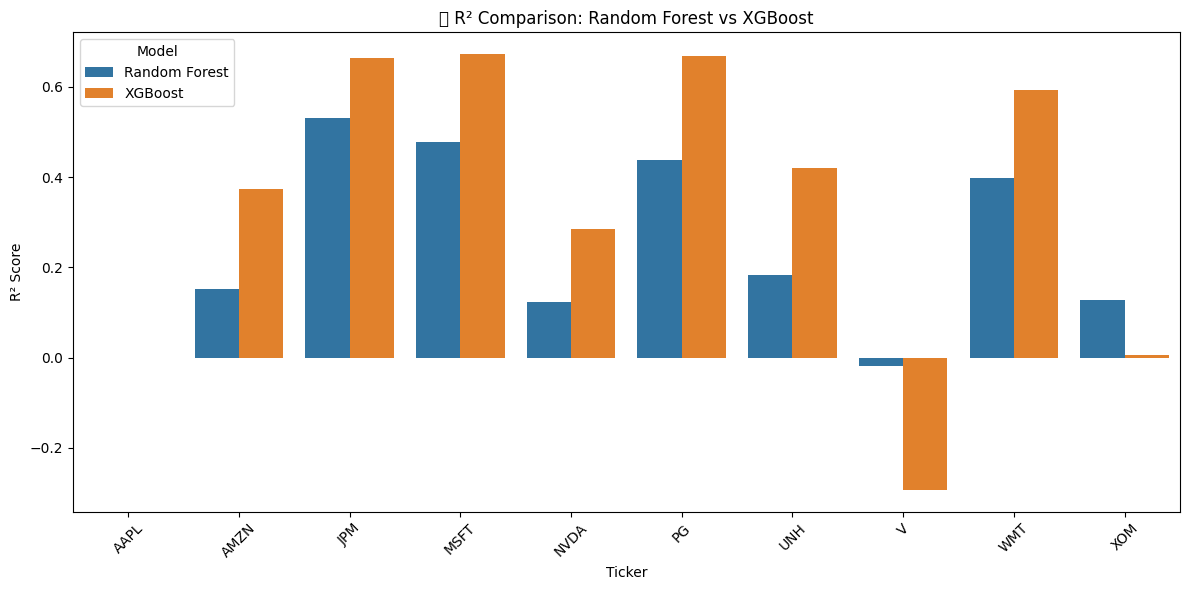

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Ticker", y="R2", hue="Model")
plt.title("📈 R² Comparison: Random Forest vs XGBoost")
plt.ylabel("R² Score")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("r2_comparison.png")
plt.show()


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load dataset
strategy_df_complete = strategy_df_9.copy()
strategy_df_complete = strategy_df_complete.dropna(subset=["After_Hours_Change%"])

y = strategy_df_complete["After_Hours_Change%"]
cols_to_drop = ["Ticker", "Date", "Earnings_Date", "Company", "After_Hours_Change%", "Regular_Change%"]
X = strategy_df_complete.drop(columns=[col for col in cols_to_drop if col in strategy_df_complete.columns])

# Clean up
X.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in X.columns:
    if X[col].dtype in ["float64", "int64"]:
        X[col].fillna(0, inplace=True)
    else:
        X[col].fillna("missing", inplace=True)

# Preprocessing
num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)
print(f"✅ Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, rf_preds)):.4f}")
print(f"✅ Random Forest R²: {r2_score(y_test, rf_preds):.4f}")
# Make these accessible globally (for Dash)
rf_actuals = y_test.values



# XGBoost
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(n_estimators=100, random_state=42))
])
xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)
print(f"✅ XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, xgb_preds)):.4f}")
print(f"✅ XGBoost R²: {r2_score(y_test, xgb_preds):.4f}")
xgb_actuals = y_test.values


<ipython-input-20-42c0bba9b7a1>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(0, inplace=True)
<ipython-input-20-42c0bba9b7a1>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({co

✅ Random Forest RMSE: 1.6676
✅ Random Forest R²: 0.7478
✅ XGBoost RMSE: 1.7601
✅ XGBoost R²: 0.7190


In [26]:
def evaluate_models_for_window(window_size, strategy_df):
    # Load dataset
    strategy_df_complete = strategy_df.copy()
    strategy_df_complete = strategy_df_complete.dropna(subset=["After_Hours_Change%"])

    y = strategy_df_complete["After_Hours_Change%"]
    cols_to_drop = ["Ticker", "Date", "Earnings_Date", "Company", "After_Hours_Change%", "Regular_Change%"]
    X = strategy_df_complete.drop(columns=[col for col in cols_to_drop if col in strategy_df_complete.columns])

    # Clean up
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    for col in X.columns:
        if X[col].dtype in ["float64", "int64"]:
            X[col].fillna(0, inplace=True)
        else:
            X[col].fillna("missing", inplace=True)

    # Preprocessing
    num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest
    rf_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    rf_pipeline.fit(X_train, y_train)
    rf_preds = rf_pipeline.predict(X_test)
    print(f"✅ Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, rf_preds)):.4f}")
    print(f"✅ Random Forest R²: {r2_score(y_test, rf_preds):.4f}")
    # Make these accessible globally (for Dash)
    rf_actuals = y_test.values



    # XGBoost
    xgb_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", XGBRegressor(n_estimators=100, random_state=42))
    ])
    xgb_pipeline.fit(X_train, y_train)
    xgb_preds = xgb_pipeline.predict(X_test)
    print(f"✅ XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, xgb_preds)):.4f}")
    print(f"✅ XGBoost R²: {r2_score(y_test, xgb_preds):.4f}")
    xgb_actuals = y_test.values

    metrics_df = pd.DataFrame([
        {"Model": "Random Forest", "Window" : window_size  , "RMSE": np.sqrt(mean_squared_error(y_test, rf_preds)), "R2": r2_score(y_test, rf_preds)},
        {"Model": "XGBoost", "Window" : window_size  , "RMSE": np.sqrt(mean_squared_error(y_test, xgb_preds)), "R2": r2_score(y_test, xgb_preds)}
    ])
    return metrics_df


evaluation_comparison_df = pd.DataFrame({
    'window_size': [1, 3, 5, 7, 9],
    'strategy': [strategy_df_1, strategy_df_3, strategy_df_5, strategy_df_7, strategy_df_9]
})

cumulative_result_df = pd.DataFrame()
for _, row in evaluation_comparison_df.iterrows():
    window_size = row['window_size']
    strategy_df = row['strategy']

    result_df = evaluate_models_for_window(window_size, strategy_df)

    cumulative_result_df = pd.concat([cumulative_result_df, result_df], ignore_index=True)

# Final result
print(cumulative_result_df)


<ipython-input-26-1199ad5871ec>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(0, inplace=True)
<ipython-input-26-1199ad5871ec>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({co

✅ Random Forest RMSE: 2.5063
✅ Random Forest R²: 0.4101
✅ XGBoost RMSE: 2.1442
✅ XGBoost R²: 0.5682


<ipython-input-26-1199ad5871ec>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(0, inplace=True)
<ipython-input-26-1199ad5871ec>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({co

✅ Random Forest RMSE: 5.2568
✅ Random Forest R²: 0.6209
✅ XGBoost RMSE: 3.3694
✅ XGBoost R²: 0.8443


<ipython-input-26-1199ad5871ec>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(0, inplace=True)
<ipython-input-26-1199ad5871ec>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({co

✅ Random Forest RMSE: 2.2404
✅ Random Forest R²: 0.5939
✅ XGBoost RMSE: 1.9659
✅ XGBoost R²: 0.6873


<ipython-input-26-1199ad5871ec>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(0, inplace=True)
<ipython-input-26-1199ad5871ec>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({co

✅ Random Forest RMSE: 1.3815
✅ Random Forest R²: 0.8004
✅ XGBoost RMSE: 1.5660
✅ XGBoost R²: 0.7435


<ipython-input-26-1199ad5871ec>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(0, inplace=True)
<ipython-input-26-1199ad5871ec>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({co

✅ Random Forest RMSE: 1.6676
✅ Random Forest R²: 0.7478
✅ XGBoost RMSE: 1.7601
✅ XGBoost R²: 0.7190
           Model  Window      RMSE        R2
0  Random Forest       1  2.506317  0.410127
1        XGBoost       1  2.144249  0.568245
2  Random Forest       3  5.256794  0.620936
3        XGBoost       3  3.369444  0.844265
4  Random Forest       5  2.240423  0.593882
5        XGBoost       5  1.965937  0.687298
6  Random Forest       7  1.381469  0.800383
7        XGBoost       7  1.566039  0.743480
8  Random Forest       9  1.667627  0.747789
9        XGBoost       9  1.760149  0.719027


In [31]:
cumulative_result_df.head()

cumulative_result_df.to_csv("cumulative_result_df.csv", index=False)
print("✅ Saved to cumulative_result_df.csv")

google.colab.files.download("cumulative_result_df.csv")

✅ Saved to cumulative_result_df.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

For Window 1:
✅ Random Forest RMSE: 2.5063
✅ Random Forest R²: 0.4101
✅ XGBoost RMSE: 2.1442
✅ XGBoost R²: 0.5682


For Window 3:
✅ Random Forest RMSE: 5.2568
✅ Random Forest R²: 0.6209
✅ XGBoost RMSE: 3.3694
✅ XGBoost R²: 0.8443

For Window 5:
✅ Random Forest RMSE: 2.2404
✅ Random Forest R²: 0.5939
✅ XGBoost RMSE: 1.9659
✅ XGBoost R²: 0.6873

For Window 7:
✅ Random Forest RMSE: 1.3815
✅ Random Forest R²: 0.8004
✅ XGBoost RMSE: 1.5660
✅ XGBoost R²: 0.7435

For Window 9:
✅ Random Forest RMSE: 1.6676
✅ Random Forest R²: 0.7478
✅ XGBoost RMSE: 1.7601
✅ XGBoost R²: 0.7190





In [ ]:
import pandas as pd

# Combine into DataFrame
results_df = pd.DataFrame({
    "Model": ["Random Forest"] * len(y_test) + ["XGBoost"] * len(y_test),
    "True": np.concatenate([y_test.values, y_test.values]),
    "Predicted": np.concatenate([rf_preds, xgb_preds])
})

# Save to CSV
results_df.to_csv("global_model_predictions.csv", index=False)
print("✅ Exported predictions to global_model_predictions.csv")

import google.colab

google.colab.files.download("global_model_predictions.csv")




✅ Exported predictions to global_model_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
metrics_df = pd.DataFrame([
    {"Model": "Random Forest", "RMSE": np.sqrt(mean_squared_error(y_test, rf_preds)), "R2": r2_score(y_test, rf_preds)},
    {"Model": "XGBoost", "RMSE": np.sqrt(mean_squared_error(y_test, xgb_preds)), "R2": r2_score(y_test, xgb_preds)}
])

metrics_df.to_csv("global_model_metrics.csv", index=False)
print("✅ Exported metrics to global_model_metrics.csv")

import google.colab

google.colab.files.download("global_model_metrics.csv")


✅ Exported metrics to global_model_metrics.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
strategy_df.head()

,Ticker,Earnings_Date,Date,Days_From_Earnings,Open,Close,Next_Day_Open,Regular_Change%,After_Hours_Change%,EPS_Actual,EPS_Estimate,EPS_Surprise,EPS_Surprise_%,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs
0,AAPL,2018-11-01,2018-10-12,-3,41.250000,42.400002,41.250000,2.787882,-2.712268,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
1,AAPL,2018-11-01,2018-10-12,-2,41.250000,42.400002,41.250000,2.787882,-2.712268,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
2,AAPL,2018-11-01,2018-10-12,-1,41.250000,42.400002,43.647499,2.787882,2.942211,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
3,AAPL,2018-11-01,2018-11-01,0,43.647499,43.820000,43.647499,0.395213,-0.393657,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
4,AAPL,2018-11-01,2018-11-01,1,43.647499,43.820000,43.647499,0.395213,-0.393657,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# 🔁 STEP 1: Normalize & Select
# -------------------------------
features = ['Open', 'Close', 'Next_Day_Open', 'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise_%']
target = 'After_Hours_Change%'

df_lstm = strategy_df.copy()
df_lstm = df_lstm.dropna(subset=features + [target])

# MinMax scale
scaler = MinMaxScaler()
df_lstm[features + [target]] = scaler.fit_transform(df_lstm[features + [target]])

# -------------------------------
# 🪜 STEP 2: Create sequences (±3)
# -------------------------------
X_seq, y_seq = [], []
seq_len = 7
center_index = 3

grouped = df_lstm.groupby(['Ticker', 'Earnings_Date'])

for _, group in grouped:
    group = group.sort_values(by='Days_From_Earnings')
    if len(group) == seq_len:
        X_seq.append(group[features].values)
        y_seq.append(group[target].values[center_index])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"✅ Final shape: {X_seq.shape}")

# -------------------------------
# 🏋️ STEP 3: Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# -------------------------------
# 🧠 STEP 4: LSTM Model
# -------------------------------
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# -------------------------------
# 📈 STEP 5: Evaluate
# -------------------------------
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📉 LSTM RMSE: {rmse:.4f}")
print(f"📈 LSTM R² Score: {r2:.4f}")

# -------------------------------
# 💾 STEP 6: Save Metrics & Output
# -------------------------------
lstm_metrics = pd.DataFrame([{
    "Model": "LSTM",
    "RMSE": round(rmse, 4),
    "R2": round(r2, 4)
}])

lstm_metrics.to_csv("lstm_metrics.csv", index=False)




metrics_df = pd.concat([metrics_df, lstm_metrics], ignore_index=True)

# Save updated file
metrics_df.to_csv("global_model_metrics.csv", index=False)
print("✅ LSTM metrics appended to global_model_metrics.csv")

# Predictions for dashboard
lstm_predictions = pd.DataFrame({
    "Model": "LSTM",
    "True": y_test.flatten(),
    "Predicted": y_pred.flatten()
})

lstm_predictions.to_csv("global_model_predictions_lstm.csv", index=False)
print("✅ Saved: lstm_metrics.csv and global_model_predictions_lstm.csv")

results_df = pd.concat([results_df, lstm_predictions], ignore_index=True)

# Save updated file
results_df.to_csv("global_model_predictions.csv", index=False)
print("✅ LSTM predictions appended to global_model_predictions.csv")

google.colab.files.download("global_model_metrics.csv")
google.colab.files.download("global_model_predictions.csv")



✅ Final shape: (1282, 7, 6)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0139 - mae: 0.0876 - val_loss: 2.2724e-04 - val_mae: 0.0125
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0101e-04 - mae: 0.0108 - val_loss: 1.4534e-04 - val_mae: 0.0076
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.6445e-05 - mae: 0.0061 - val_loss: 1.0045e-04 - val_mae: 0.0053
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0020e-04 - mae: 0.0058 - val_loss: 9.4418e-05 - val_mae: 0.0049
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0298e-05 - mae: 0.0050 - val_loss: 8.7953e-05 - val_mae: 0.0047
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.8737e-05 - mae: 0.0052 - val_loss: 8.1193e-05 - val_mae: 0.0047
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.9913e-05 - mae: 0.0054 - val_loss: 7.8195e-05 - val_mae: 0.0045
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.9524e-05 - mae: 0.0047 - val_loss: 7.0402e-05 - val_mae: 0.0048
Epoch 9/50
33/33 ━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Assuming you already have:
# - y_test (true values for LSTM)
# - lstm_preds (predictions from your LSTM model)

results_df = pd.DataFrame({
    "Model": (
        ["Random Forest"] * len(y_test) +
        ["XGBoost"] * len(y_test) +
        ["LSTM"] * len(y_test)
    ),
    "True": np.concatenate([y_test.values, y_test.values, y_test]),
    "Predicted": np.concatenate([rf_preds, xgb_preds, lstm_preds.flatten()])
})

results_df.to_csv("global_model_predictions.csv", index=False)
print("✅ All model predictions exported to global_model_predictions.csv")

google.colab.files.download("global_model_predictions.csv")


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

def run_backtest_signal_model(strategy_df, long_threshold=2.0, short_threshold=-2.0):
    # Filter Day 0 (earnings day)
    day0_df = strategy_df[strategy_df["Days_From_Earnings"] == 0].copy()
    day0_df = day0_df.dropna(subset=["After_Hours_Change%"])

    # Features and Target
    y = day0_df["After_Hours_Change%"]
    drop_cols = ["Ticker", "Date", "Earnings_Date", "Company", "After_Hours_Change%", "Regular_Change%"]
    X = day0_df.drop(columns=[col for col in drop_cols if col in day0_df.columns])

    # Clean data
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    for col in X.columns:
        if X[col].dtype in ["float64", "int64"]:
            X[col].fillna(0, inplace=True)
        else:
            X[col].fillna("missing", inplace=True)

    num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", XGBRegressor(n_estimators=100, random_state=42))
    ])
    pipeline.fit(X_train, y_train)

    # Predict for all day0 rows
    X_all = preprocessor.fit_transform(X)
    day0_df["Predicted_Change"] = pipeline.named_steps["model"].predict(X_all)

    # Trading Logic
    def simulate_trades(row):
        pred = row["Predicted_Change"]
        close = row["Close"]
        next_open = row["Next_Day_Open"]
        if pred >= long_threshold:
            return np.log(next_open / close)
        elif pred <= short_threshold:
            return np.log(close / next_open)
        else:
            return 0.0

    day0_df["Trade_Return"] = day0_df.apply(simulate_trades, axis=1)
    day0_df["Cumulative_Return"] = day0_df["Trade_Return"].cumsum()

    # Summary Statistics
    total_trades = (day0_df["Trade_Return"] != 0).sum()
    win_trades = (day0_df["Trade_Return"] > 0).sum()
    win_rate = round((win_trades / total_trades) * 100, 2) if total_trades > 0 else 0
    avg_return = round(day0_df["Trade_Return"].mean(), 4)
    cum_return = round(day0_df["Cumulative_Return"].iloc[-1], 4)
    cum_pct = round((np.exp(cum_return) - 1) * 100, 2)

    summary = {
        "Total Trades": total_trades,
        "Win Rate (%)": win_rate,
        "Avg Return": avg_return,
        "Cumulative Log Return": cum_return,
        "Cumulative Return (%)": cum_pct
    }

    return day0_df, summary


In [34]:
results_df, summary_stats = run_backtest_signal_model(strategy_df_7)

summary_stats


<ipython-input-32-c83860f8a770>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(0, inplace=True)
<ipython-input-32-c83860f8a770>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({co

{'Total Trades': np.int64(634),
 'Win Rate (%)': np.float64(94.32),
 'Avg Return': np.float64(0.0111),
 'Cumulative Log Return': np.float64(32.3928),
 'Cumulative Return (%)': np.float64(1.1695378819362636e+16)}

In [38]:
strategy_df_7.head()

,Ticker,Earnings_Date,Date,Days_From_Earnings,Open,Close,Next_Day_Open,Regular_Change%,After_Hours_Change%,EPS_Actual,EPS_Estimate,EPS_Surprise,EPS_Surprise_%,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs
0,AAPL,2022-10-27,2022-11-01,5,172.320007,175.080002,172.320007,1.601668,-1.576419,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
1,AAPL,2022-10-27,2022-11-01,5,172.320007,175.080002,172.320007,1.601668,-1.576419,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
2,AAPL,2022-10-27,2022-11-01,5,172.320007,175.080002,172.330002,1.601668,-1.570711,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
3,AAPL,2022-10-27,2022-11-02,6,172.330002,168.639999,172.330002,-2.141242,2.188094,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no
4,AAPL,2022-10-27,2022-11-02,6,172.330002,168.639999,172.330002,-2.141242,2.188094,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the data
strategy_df = strategy_df_7.copy()

# Drop rows with missing target
strategy_df = strategy_df.dropna(subset=["After_Hours_Change%"])

# Clean categorical explosion
drop_cols = ["Date", "Company", "Next_Day_Open", "Regular_Change%"]
strategy_df = strategy_df.drop(columns=[col for col in drop_cols if col in strategy_df.columns])

# Define inputs and target
y = strategy_df["After_Hours_Change%"]
X = strategy_df.drop(columns=["After_Hours_Change%"], errors="ignore")

# Clean up
X.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in X.columns:
    if X[col].dtype in ["float64", "int64"]:
        X[col] = X[col].fillna(0)
    else:
        X[col] = X[col].fillna("missing")

# Limit categorical columns
high_card_cols = ['Company', 'Industry']
cat_cols = [col for col in X.select_dtypes(include=["object"]).columns if col not in high_card_cols]
num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost pipeline
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(n_estimators=100, random_state=42))
])
xgb_pipeline.fit(X_train, y_train)

# Predict on full dataset
X_all_transformed = xgb_pipeline.named_steps["preprocessor"].transform(X)
predictions = xgb_pipeline.named_steps["model"].predict(X_all_transformed)

# Add to dataframe
strategy_df["Predicted_After_Hours_Change%"] = predictions
strategy_df["Signal"] = np.where(strategy_df["Predicted_After_Hours_Change%"] > 0, 1, -1)

# ✅ Final cleaned dataset ready for signal generation
# ✅ Final cleaned dataset ready for signal generation
strategy_df.head()



,Ticker,Earnings_Date,Days_From_Earnings,Open,Close,After_Hours_Change%,EPS_Actual,EPS_Estimate,EPS_Surprise,EPS_Surprise_%,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs,Predicted_After_Hours_Change%,Signal
0,AAPL,2022-10-27,5,172.320007,175.080002,-1.576419,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no,-0.198602,-1
1,AAPL,2022-10-27,5,172.320007,175.080002,-1.576419,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no,-0.198602,-1
2,AAPL,2022-10-27,5,172.320007,175.080002,-1.570711,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no,-0.198602,-1
3,AAPL,2022-10-27,6,172.330002,168.639999,2.188094,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no,-0.219630,-1
4,AAPL,2022-10-27,6,172.330002,168.639999,2.188094,1.29,1.27,0.02,1.5748,Technology,"Computers, Office Equipment",yes,no,no,no,-0.219630,-1


In [51]:
import pandas as pd
import numpy as np

# Load the original strategy_df (window=7)
df = strategy_df_7.copy()

# Drop rows with missing target
df = df.dropna(subset=["After_Hours_Change%"])

# ✂️ Columns we don't want to use as features
leakage_cols = ["Next_Day_Open", "After_Hours_Change%", "Regular_Change%", "Ticker", "Date", "Earnings_Date", "Company"]

# Features and Target
y = df["After_Hours_Change%"]
X = df.drop(columns=[col for col in leakage_cols if col in df.columns])

# Fill missing values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in X.columns:
    if X[col].dtype in ["float64", "int64"]:
        X[col].fillna(0, inplace=True)
    else:
        X[col].fillna("missing", inplace=True)

# 🔁 Reuse the same preprocessing pipeline as used in training
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(n_estimators=100, random_state=42))
])

# Train and predict
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_pipeline.fit(X_train, y_train)

# Predict on entire data
X_all_processed = preprocessor.fit_transform(X)
df["Predicted"] = xgb_pipeline.named_steps["model"].predict(X_all_processed)

# Save to CSV
df.to_csv("strategy_df_with_signals.csv", index=False)
print("✅ Saved updated strategy_df_with_signals.csv with Predicted column.")


<ipython-input-51-6b8186002c49>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(0, inplace=True)
<ipython-input-51-6b8186002c49>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({co

✅ Saved updated strategy_df_with_signals.csv with Predicted column.


In [46]:
strategy_df.to_csv("strategy_df_with_signals.csv", index=False)
print("✅ Exported cleaned signal data to strategy_df_with_signals.csv")


✅ Exported cleaned signal data to strategy_df_with_signals.csv


In [47]:
from google.colab import files
files.download("strategy_df_with_signals.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your cleaned strategy data
df = strategy_df.copy()

# Sort by Ticker, Earnings_Date, and Days_From_Earnings
df = df.sort_values(["Ticker", "Earnings_Date", "Days_From_Earnings"])

# 💡 Step 1: Use predictions to generate trading signals
# We'll assume: Buy if predicted After_Hours_Change > 0, else Hold
df["Signal"] = (df["Predicted"] > 0).astype(int)

# 💡 Step 2: Filter only Day 0 (Earnings Day)
day0 = df[df["Days_From_Earnings"] == 0].copy()

# 💡 Step 3: Simulate Strategy
# Buy at "Open", sell at "Next_Day_Open" → Gain = (Next_Day_Open - Open) / Open
day0["Trade_Return"] = (day0["Next_Day_Open"] - day0["Open"]) / day0["Open"]
day0["Trade_Return"] = day0["Trade_Return"] * day0["Signal"]  # Only apply returns where Signal == 1

# 💡 Step 4: Compute Performance Metrics
total_trades = day0["Signal"].sum()
profitable_trades = ((day0["Trade_Return"] > 0) & (day0["Signal"] == 1)).sum()
win_rate = 100 * profitable_trades / total_trades if total_trades > 0 else 0
avg_return = day0["Trade_Return"].mean()
cumulative_return = (1 + day0["Trade_Return"]).prod() - 1
cumulative_log_return = np.log1p(day0["Trade_Return"]).sum()

performance = {
    "Total Trades": total_trades,
    "Win Rate (%)": round(win_rate, 2),
    "Avg Return": round(avg_return, 4),
    "Cumulative Return (%)": round(cumulative_return * 100, 2),
    "Cumulative Log Return": round(cumulative_log_return, 4)
}

# 💹 Step 5: Plot equity curve
day0["Equity Curve"] = (1 + day0["Trade_Return"]).cumprod()
plt.figure(figsize=(10, 5))
plt.plot(day0["Date"], day0["Equity Curve"])
plt.title("📈 Equity Curve: Signal-Based Strategy")
plt.xlabel("Date")
plt.ylabel("Equity Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Show Performance
print("📊 Strategy Performance:")
for k, v in performance.items():
    print(f"{k}: {v}")


KeyError: 'Predicted'

<ipython-input-22-486b6ea75bd0>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna("missing", inplace=True)
<ipython-input-22-486b6ea75bd0>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

count    34014.000000
mean         0.101103
std          0.226578
min         -0.500000
25%          0.035813
50%          0.085764
75%          0.183295
max          0.500000
Name: Predicted, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-22-486b6ea75bd0>:74: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


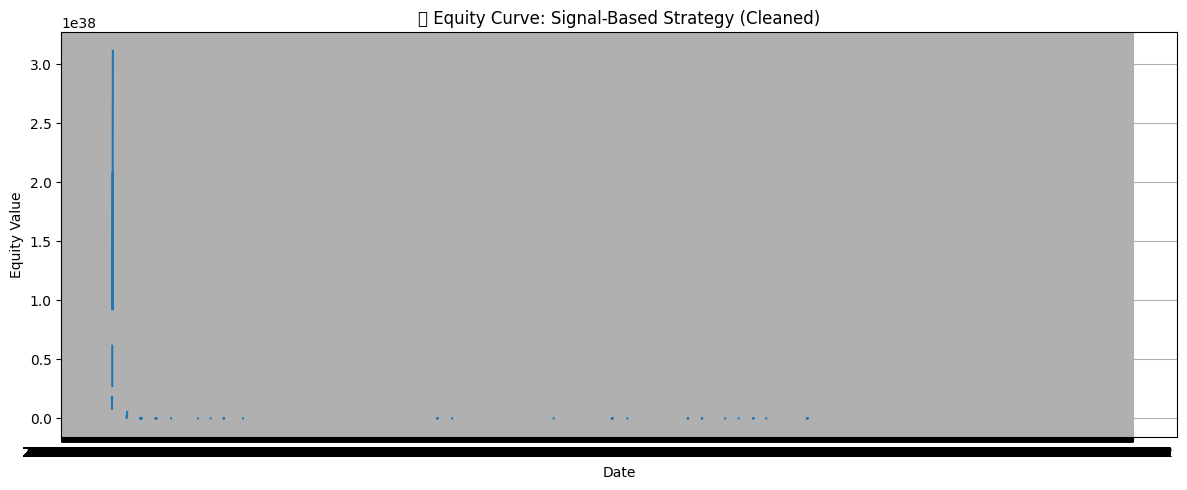

📊 Strategy Performance (Cleaned):
{'Total Trades': 6856, 'Win Rate (%)': np.float64(66.04), 'Avg Return': np.float64(0.0988), 'Cumulative Return (%)': np.float32(inf), 'Cumulative Log Return': np.float32(2426.2126)}


In [22]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# ⚠️ 1. Remove all known leakage columns
leakage_cols = ["Next_Day_Open", "Regular_Change%", "Predicted"]
df = strategy_df_7.copy()
df = df.drop(columns=[col for col in leakage_cols if col in df.columns], errors="ignore")

# 🧼 2. Drop rows with missing target
#df = df.dropna(subset=["After_Hours_Change%"])

# 🏗️ 3. Rebuild features
y = df["After_Hours_Change%"]
X = df.drop(columns=[ "Date", "Company"], errors="ignore")

# 🔧 4. Handle NaNs
X.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in X.columns:
    if X[col].dtype in ["float64", "int64"]:
        X[col].fillna(0, inplace=True)
    else:
        X[col].fillna("missing", inplace=True)

# 🔁 5. Preprocessing pipeline
num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_processed = preprocessor.fit_transform(X)

# 🎯 6. Use previously trained pipeline model (must match columns!)
preds = xgb_pipeline.predict(X)

# 🧠 7. Restore to df and generate realistic signals
df["Predicted"] = preds
df['Predicted'] = df['Predicted'].clip(lower=-0.5, upper=0.5)  # Cap to ±50% change

print(df['Predicted'].describe())


threshold = np.percentile(preds, 80)  # You can tweak this
df["Signal"] = (df["Predicted"] >= threshold).astype(int)

# 📉 8. Return Calculation
df["Strategy_Return"] = df["Signal"] * y
df["Strategy_Return"] = df["Strategy_Return"].clip(lower=-0.3, upper=0.3)  # Avoid exploding

df["Log_Return"] = np.log1p(df["Strategy_Return"])
df['Log_Return'] = np.log(1 + df['Predicted'])  # Make sure it's not < -1
df['Equity'] = np.exp(df['Log_Return'].cumsum())

df["Cumulative_Log_Return"] = df["Log_Return"].cumsum()
df["Cumulative_Return"] = np.exp(df["Cumulative_Log_Return"])

df = df[df['Predicted'] > -1]  # log(0) is undefined


# 🎨 9. Plot Clean Equity Curve
import matplotlib.pyplot as plt

df_sorted = df.sort_values("Date")
plt.figure(figsize=(12, 5))
plt.plot(df_sorted["Date"], df_sorted["Cumulative_Return"])
plt.title("📈 Equity Curve: Signal-Based Strategy (Cleaned)")
plt.xlabel("Date")
plt.ylabel("Equity Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 10. Summary Stats
stats = {
    "Total Trades": int(df["Signal"].sum()),
    "Win Rate (%)": round((df[df["Signal"] == 1]["Strategy_Return"] > 0).mean() * 100, 2),
    "Avg Return": round(df[df["Signal"] == 1]["Strategy_Return"].mean(), 4),
    "Cumulative Return (%)": round(df["Cumulative_Return"].iloc[-1] * 100, 2),
    "Cumulative Log Return": round(df["Cumulative_Log_Return"].iloc[-1], 4),
}
print("📊 Strategy Performance (Cleaned):")
print(stats)


📊 Strategy Performance:
Total Trades: 6757
Win Rate (%): 66.27
Avg Return: 0.1650
Cumulative Return (%): 21067043756705285190138227195007337582779380325455212442982001420876340479057608050774841167983655885876026963175151738272776810109930542276270000512454786711376481681396404930478080.00
Cumulative Log Return: 412.9079


<ipython-input-15-b288091839a3>:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


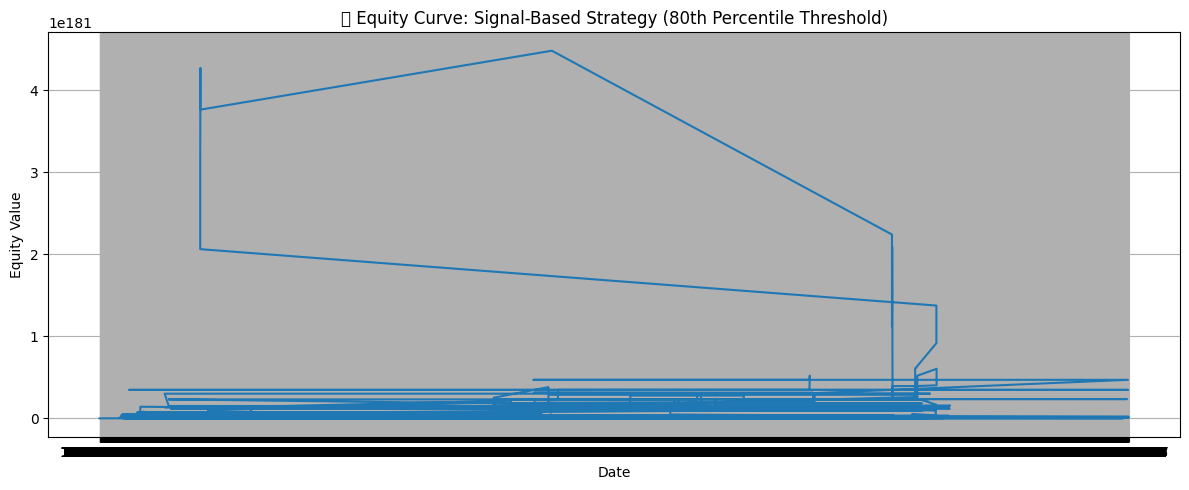

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data

# Clean & prepare
df["After_Hours_Change%"] = df["After_Hours_Change%"].clip(-0.5, 0.5)
threshold = np.percentile(df["Predicted"], 80)
df["Signal"] = (df["Predicted"] > threshold).astype(int)
df = df.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)

# Simulate strategy
df["Strategy_Return"] = df["Signal"] * df["After_Hours_Change%"]
df["Cumulative_Log_Return"] = np.log1p(df["Strategy_Return"]).cumsum()
df["Cumulative_Return"] = np.exp(df["Cumulative_Log_Return"])

# Performance metrics
total_trades = df["Signal"].sum()
win_rate = (df[df["Signal"] == 1]["After_Hours_Change%"] > 0).mean() * 100
avg_return = df[df["Signal"] == 1]["After_Hours_Change%"].mean()
cum_log_return = df["Cumulative_Log_Return"].iloc[-1]
cum_return_pct = (df["Cumulative_Return"].iloc[-1] - 1) * 100

print("📊 Strategy Performance:")
print(f"Total Trades: {total_trades}")
print(f"Win Rate (%): {win_rate:.2f}")
print(f"Avg Return: {avg_return:.4f}")
print(f"Cumulative Return (%): {cum_return_pct:.2f}")
print(f"Cumulative Log Return: {cum_log_return:.4f}")

# 📈 Plot
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Cumulative_Return"])
plt.title("📈 Equity Curve: Signal-Based Strategy (80th Percentile Threshold)")
plt.xlabel("Date")
plt.ylabel("Equity Value")
plt.grid(True)
plt.tight_layout()
plt.show()


📊 Strategy Performance (Cleaned):
Total Trades: 34014
Win Rate (%): 59.00
Avg Return: 0.0659
Cumulative Return (%): -100.00
Cumulative Log Return: -257.8623


<ipython-input-23-5a8cb16a18dc>:52: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


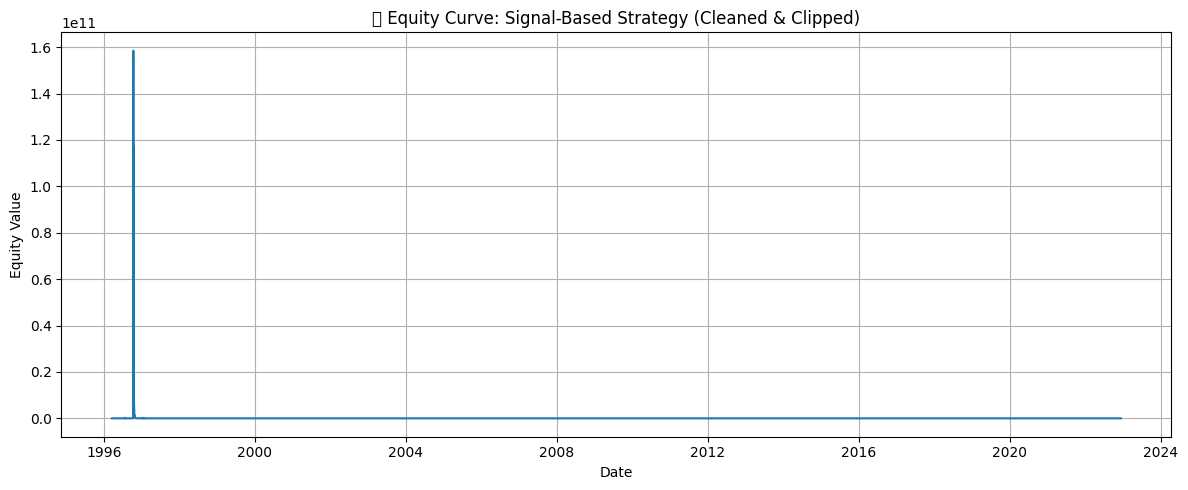

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1. Load the strategy DataFrame ===
df = pd.read_csv("strategy_df_with_signals.csv", parse_dates=["Date"])

# === 2. Ensure Data is sorted correctly ===
df = df.sort_values(by=["Ticker", "Date"])

# === 3. Drop rows with missing prediction values (if any) ===
df = df.dropna(subset=["Predicted"])

# === 4. Clip extreme values to avoid exponential blow-up ===
df["Predicted"] = df["Predicted"].clip(lower=-0.5, upper=0.5)

# === 5. Create log return column ===
df["Log_Return"] = np.log(1 + df["Predicted"])

# Filter out invalid log returns
df = df[df["Predicted"] > -1]

# === 6. Sort by date to simulate equity line ===
df = df.sort_values(by="Date")

# === 7. Cumulative equity curve ===
df["Cumulative_Log_Return"] = df["Log_Return"].cumsum()
df["Equity"] = np.exp(df["Cumulative_Log_Return"])

# === 8. Backtest Summary Metrics ===
total_trades = len(df)
win_rate = 100 * (df["Predicted"] > 0).sum() / total_trades
avg_return = df["Predicted"].mean()
cum_return_pct = (df["Equity"].iloc[-1] - 1) * 100
cum_log_return = df["Cumulative_Log_Return"].iloc[-1]

# === 9. Print Summary ===
print("📊 Strategy Performance (Cleaned):")
print(f"Total Trades: {total_trades}")
print(f"Win Rate (%): {win_rate:.2f}")
print(f"Avg Return: {avg_return:.4f}")
print(f"Cumulative Return (%): {cum_return_pct:.2f}")
print(f"Cumulative Log Return: {cum_log_return:.4f}")

# === 10. Plot Equity Curve ===
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Equity"])
plt.title("📈 Equity Curve: Signal-Based Strategy (Cleaned & Clipped)")
plt.xlabel("Date")
plt.ylabel("Equity Value")
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd
import numpy as np

# 👇 Your original strategy dataframe
strategy_df = strategy_df_7.copy()

# --------------------------------------------
# ✅ 1. Remove leakage columns (not for training)
# --------------------------------------------
leakage_cols = ["Next_Day_Open", "After_Hours_Change%", "Regular_Change%", "Date", "Company"]
X = strategy_df.drop(columns=[col for col in leakage_cols if col in strategy_df.columns])

# --------------------------------------------
# ✅ 2. Fill missing values to match training
# --------------------------------------------
X = X.replace([np.inf, -np.inf], np.nan)
for col in X.columns:
    if X[col].dtype in ["float64", "int64"]:
        X[col] = X[col].fillna(0)
    else:
        X[col] = X[col].fillna("missing")

# --------------------------------------------
# ✅ 3. Predict with fitted model
# --------------------------------------------
# ❗ Make sure xgb_pipeline is trained and available in memory
preds = xgb_pipeline.predict(X)

# --------------------------------------------
# ✅ 4. Add predictions to strategy_df
# --------------------------------------------
strategy_df["Predicted"] = preds

# ✅ Save or preview
strategy_df.to_csv("strategy_df_with_predictions.csv", index=False)
print("✅ Predictions saved to strategy_df_with_predictions.csv")
display(strategy_df[["Ticker", "Date", "Days_From_Earnings", "Predicted"]].head())


✅ Predictions saved to strategy_df_with_predictions.csv


,Ticker,Date,Days_From_Earnings,Predicted
0,AAPL,2022-11-01,5,-0.198602
1,AAPL,2022-11-01,5,-0.198602
2,AAPL,2022-11-01,5,-0.198602
3,AAPL,2022-11-02,6,-0.219630
4,AAPL,2022-11-02,6,-0.219630


In [29]:
def simulate_entry_exit_signals(df, window=3):
    results = []

    grouped = df.groupby(["Ticker", "Earnings_Date"])

    for (ticker, earnings_date), group in grouped:
        group = group.sort_values("Days_From_Earnings")
        if group["Days_From_Earnings"].min() > -window or group["Days_From_Earnings"].max() < window:
            continue

        # 🔍 Entry: day with highest predicted return in pre-earnings window
        pre_window = group[group["Days_From_Earnings"] < 0]
        if pre_window.empty:
            continue

        entry_row = pre_window.loc[pre_window["Predicted"].idxmax()]
        entry_day = entry_row["Days_From_Earnings"]

        # 🏁 Exit: earnings day (or choose +1, etc.)
        exit_day = 0
        if not (group["Days_From_Earnings"] == exit_day).any():
            continue

        exit_row = group[group["Days_From_Earnings"] == exit_day].iloc[0]

        # 📈 Calculate return (open to next open)
        realized_return = np.log(exit_row["Next_Day_Open"] / entry_row["Open"])

        results.append({
            "Ticker": ticker,
            "Earnings_Date": earnings_date,
            "Entry_Day": entry_day,
            "Exit_Day": exit_day,
            "Predicted": entry_row["Predicted"],
            "Realized_Log_Return": realized_return,
            "Direction_Correct": np.sign(realized_return) == np.sign(entry_row["Predicted"])
        })

    return pd.DataFrame(results)


In [31]:
# Run simulation
signal_df = simulate_entry_exit_signals(strategy_df, window=3)

# Evaluate
win_rate = 100 * signal_df["Direction_Correct"].mean()
avg_return = signal_df["Realized_Log_Return"].mean()
total_trades = len(signal_df)

print(f"📈 Entry/Exit Strategy Results")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Avg Log Return: {avg_return:.4f}")


📈 Entry/Exit Strategy Results
Total Trades: 1220
Win Rate: 56.23%
Avg Log Return: 0.0065


📈 Entry/Exit Strategy Results
Total Trades: 2525
Win Rate: 22.10%
Avg Log Return: 0.0010
Cumulative Log Return: 3.0267
Cumulative Return (%): 1962.85%


<ipython-input-32-a0eb5296e491>:45: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


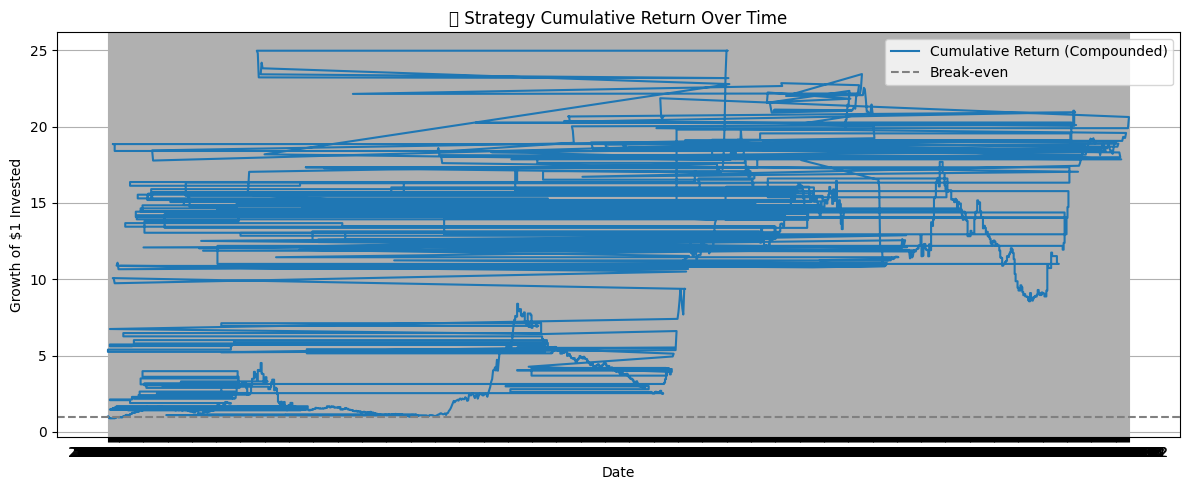

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 🔁 Load your strategy DataFrame
df = strategy_df.copy()

# 🎯 Filter to only earnings day
df_day0 = df[df["Days_From_Earnings"] == 0].copy()

# ✅ Simple Entry Rule: Buy if Predicted > 0
df_day0["Signal"] = (df_day0["Predicted"] > 0).astype(int)

# 🎯 Simulate holding next day (from open to next day's open)
df_day0["Next_Return"] = np.log(df_day0["Next_Day_Open"] / df_day0["Open"])
df_day0["Trade_Return"] = df_day0["Next_Return"] * df_day0["Signal"]

# 🧮 Strategy performance metrics
total_trades = df_day0["Signal"].sum()
win_rate = (df_day0[df_day0["Signal"] == 1]["Trade_Return"] > 0).mean() * 100
avg_return = df_day0["Trade_Return"].mean()
cumulative_log_return = df_day0["Trade_Return"].sum()
cumulative_return = np.exp(cumulative_log_return) - 1

# 📊 Summary
print(f"📈 Entry/Exit Strategy Results")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Avg Log Return: {avg_return:.4f}")
print(f"Cumulative Log Return: {cumulative_log_return:.4f}")
print(f"Cumulative Return (%): {cumulative_return * 100:.2f}%")

# 📈 Plot cumulative return over time
df_day0["Cumulative"] = df_day0["Trade_Return"].cumsum()
df_day0["Cumulative_Exp"] = np.exp(df_day0["Cumulative"])

plt.figure(figsize=(12, 5))
plt.plot(df_day0["Date"], df_day0["Cumulative_Exp"], label="Cumulative Return (Compounded)")
plt.axhline(1, color="gray", linestyle="--", label="Break-even")
plt.title("💰 Strategy Cumulative Return Over Time")
plt.xlabel("Date")
plt.ylabel("Growth of $1 Invested")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
